In [169]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [170]:
os.chdir(r"/Users/samueleckford/Python/Covid_19/covid_19_analysis/datasets/")

In [171]:
drop_columns = ['geoId', 'countryterritoryCode', 'day', 'month', 'year']

In [172]:
#target_country = "China"

In [206]:
# Import and format dataframe
covid19_df = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-05-05.csv', engine='python')

In [177]:
covid19_df.head(2)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,26/04/2020,26,4,2020,112,4,Afghanistan,AF,AFG,37172386.0,Asia
1,25/04/2020,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia


In [178]:
covid19_df['dateRep'] = pd.to_datetime(covid19_df['dateRep'], dayfirst=True)
covid19_df.drop(columns=drop_columns, inplace=True)
covid19_df.head(2)

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp
0,2020-04-26,112,4,Afghanistan,37172386.0,Asia
1,2020-04-25,70,1,Afghanistan,37172386.0,Asia


In [179]:
# Create df for one country
#country_df = covid19_df.loc[covid19_df.countriesAndTerritories == "China"].copy()

country_df = covid19_df.copy() 
country_df.sort_values(by=['dateRep'], ascending=True, inplace=True)
country_df.head(3)

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp
10598,2019-12-31,0,0,San_Marino,33785.0,Europe
2313,2019-12-31,0,0,Canada,37058856.0,America
8692,2019-12-31,0,0,Netherlands,17231017.0,Europe


In [180]:
# Add cumulative columns for cases and deaths
# country_df['Cum Cases'] = country_df['cases'].cumsum()
# country_df['Cum Deaths'] = country_df['deaths'].cumsum()
country_df['Cum Cases'] = country_df.groupby("countriesAndTerritories")['cases'].cumsum()
country_df['Cum Deaths'] = country_df.groupby("countriesAndTerritories")['deaths'].cumsum()
country_df.head(3)

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths
10598,2019-12-31,0,0,San_Marino,33785.0,Europe,0,0
2313,2019-12-31,0,0,Canada,37058856.0,America,0,0
8692,2019-12-31,0,0,Netherlands,17231017.0,Europe,0,0


In [181]:
# Create column for days since x deaths
country_df['flag'] = np.where(country_df['Cum Cases'] > 100, 1, 0) # this is fine to calculate globaly as its a true false, no agregaton at this stage

# Here I use the same logic as you. I filter the dataframe on cases (impartant to note i'm only filtering the grouped by dataframe). I then groupby the countriesAndTerritories
# column (again creating a unique dataframe for each country) and applying a cumulative sum to the "flag" column
country_df['flag'] = country_df.loc[country_df['Cum Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

In [182]:
# The daily percent change in case and death rates for each country individually

country_df['case_rate_inc'] = 1 + country_df.groupby("countriesAndTerritories")['cases'].pct_change()
country_df['death_rate_inc'] = 1 + country_df.groupby("countriesAndTerritories")['deaths'].pct_change()

In [183]:
# Rolling avereage of the case and deaths rates over a 5 day window using the median, mean also useful

country_df['5D_MA_cases'] = country_df.groupby("countriesAndTerritories")['case_rate_inc'].rolling(window=5).median().reset_index(0,drop=True)
country_df['5D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['death_rate_inc'].rolling(window=5).median().reset_index(0,drop=True)
country_df.loc[country_df['Cum Cases'] > 2000].groupby("countriesAndTerritories").head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,case_rate_inc,death_rate_inc,5D_MA_cases,5D_MA_deaths
2676,2020-01-27,787,25,China,1.392730e+09,Asia,2775,81,9.0,1.183459,1.666667,1.507937,NaN
2675,2020-01-28,1753,25,China,1.392730e+09,Asia,4528,106,10.0,2.227446,1.000000,1.702703,NaN
2674,2020-01-29,1466,26,China,1.392730e+09,Asia,5994,132,11.0,0.836281,1.040000,1.507937,1.040000
2673,2020-01-30,1740,38,China,1.392730e+09,Asia,7734,170,12.0,1.186903,1.461538,1.186903,1.040000
2672,2020-01-31,1980,43,China,1.392730e+09,Asia,9714,213,13.0,1.137931,1.131579,1.183459,1.131579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2020-04-25,301,0,Bahrain,1.569439e+06,Asia,2518,8,47.0,1.433333,0.000000,1.433333,NaN
6847,2020-04-26,278,4,Kuwait,4.137309e+06,Asia,2892,19,43.0,1.293023,4.000000,1.293023,1.000000
6718,2020-04-26,170,0,Kazakhstan,1.827650e+07,Asia,2652,25,31.0,1.148649,0.000000,1.034965,NaN
2887,2020-04-26,7,3,Croatia,4.089400e+06,Europe,2016,54,38.0,0.250000,3.000000,0.903226,NaN


In [184]:
# Rolling avereage of the case and deaths rates over a 5 day window using the median, mean also useful

country_df['7D_MA_cases'] = country_df.groupby("countriesAndTerritories")['case_rate_inc'].rolling(window=7).median().reset_index(0,drop=True)
country_df['7D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['death_rate_inc'].rolling(window=7).median().reset_index(0,drop=True)

In [185]:
# Find the countries with the worse deaths tally to use, top 50 usually used but can vary it

top_count = country_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:50]
#top_count = country_df['countriesAndTerritories'].value_counts().iloc[:20]
top_count

countriesAndTerritories
United_States_of_America    53189
Italy                       26384
France                      22614
Spain                       22524
United_Kingdom              20319
Belgium                      6917
Iran                         5650
Germany                      5640
China                        4636
Netherlands                  4409
Brazil                       4016
Turkey                       2706
Canada                       2465
Sweden                       2192
Switzerland                  1328
Mexico                       1305
Ireland                      1063
Portugal                      880
India                         824
Indonesia                     720
Peru                          700
Russia                        681
Ecuador                       576
Romania                       575
Austria                       536
Poland                        524
Philippines                   494
Algeria                       419
Denmark                 

In [186]:
# Create a list of just the country names to use in the analysis

top_count = list(top_count.keys())

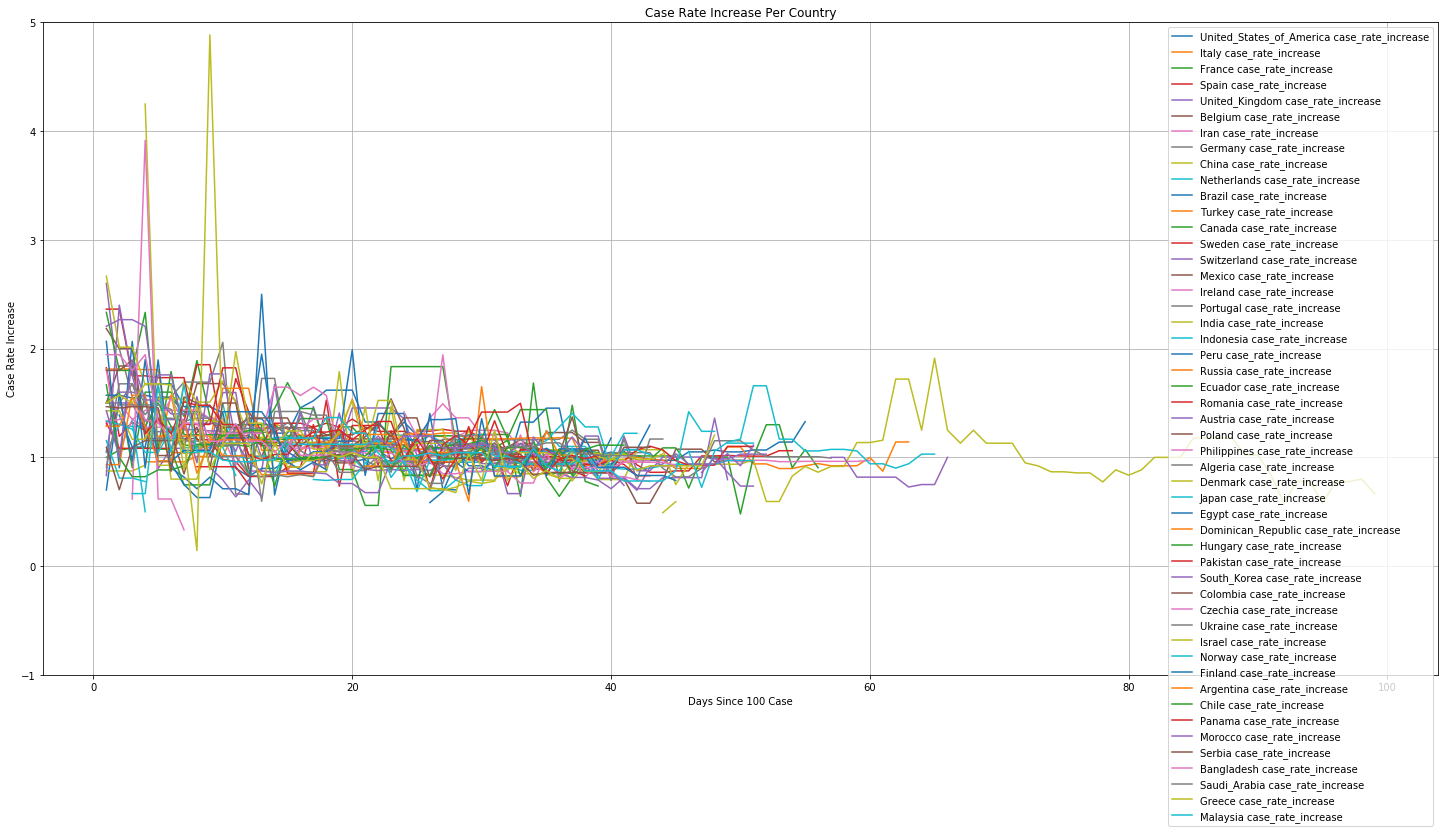

In [187]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(country_df[country_df["countriesAndTerritories"] == country]["flag"],
             country_df[country_df["countriesAndTerritories"] == country]["5D_MA_cases"], label=f"{country} case_rate_increase")
plt.title('Case Rate Increase Per Country')
plt.xlabel('Days Since 100 Case')
plt.ylabel('Case Rate Increase')
plt.ylim(-1, 5)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

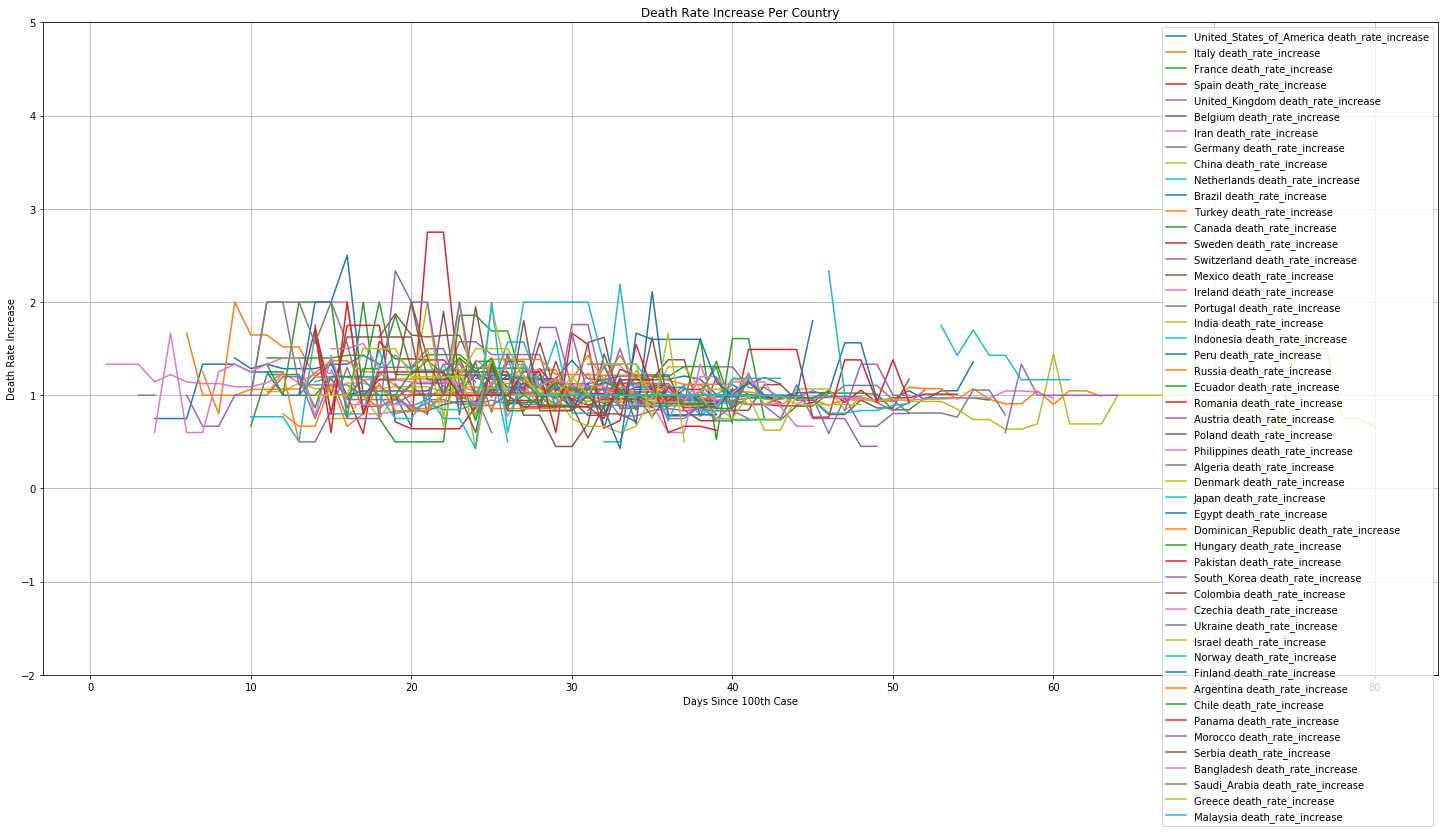

In [188]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(country_df[country_df["countriesAndTerritories"] == country]["flag"],
             country_df[country_df["countriesAndTerritories"] == country]["5D_MA_deaths"], label=f"{country} death_rate_increase")
plt.title('Death Rate Increase Per Country')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Death Rate Increase')
plt.ylim(-2, 5)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

In [189]:
country_df.flag.fillna(0, inplace=True) # fill the nans in the flag column as a reult of mergining in the filtered groupby
country_df.case_rate_inc.fillna(0, inplace=True) # fill the nans in the case rate column as a reult of mergining in the filtered groupby

In [190]:
# Here we select only the countries in the 'top_count' list and groupby 'days since 100 case' and take the mean.
# This gives us a global average per day after 100th case for a range of attributes
country_df_mean = country_df[country_df['countriesAndTerritories'].isin(top_count)].groupby('flag').mean()
country_df_mean.head()

,cases,deaths,popData2018,Cum Cases,Cum Deaths,case_rate_inc,death_rate_inc,5D_MA_cases,5D_MA_deaths,7D_MA_cases,7D_MA_deaths
flag,,,,,,,,,,,
0.0,1.596957,0.028872,1.150448e+08,7.764729,0.141631,inf,inf,1.342013,NaN,1.270015,NaN
1.0,43.300000,0.600000,1.131826e+08,125.160000,2.080000,inf,inf,1.537002,1.333333,1.450839,NaN
2.0,45.860000,0.760000,1.131826e+08,171.020000,2.840000,1.473564,inf,1.485854,1.333333,1.395085,NaN
3.0,63.100000,1.020000,1.131826e+08,234.120000,3.860000,inf,inf,1.444117,1.166667,1.493450,1.333333
4.0,71.420000,1.320000,1.131826e+08,305.540000,5.180000,inf,inf,1.460291,0.873214,1.405941,1.333333


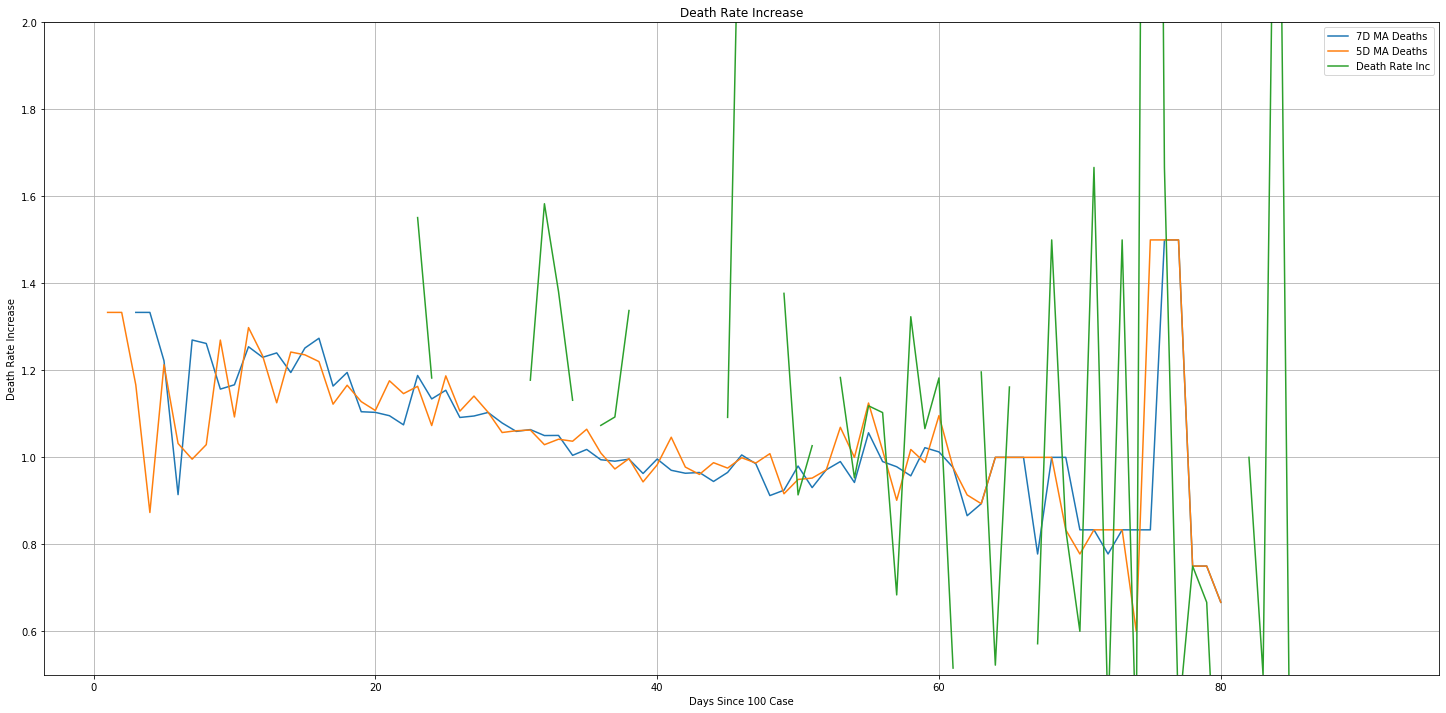

In [191]:
# Plot the global average death rate per day past 100th case.
plt.figure(figsize=(25, 12))
plt.plot(country_df_mean.index, country_df_mean['7D_MA_deaths'], label='7D MA Deaths')
plt.plot(country_df_mean.index, country_df_mean['5D_MA_deaths'], label='5D MA Deaths')
plt.plot(country_df_mean.index, country_df_mean['death_rate_inc'], label='Death Rate Inc')
plt.title('Death Rate Increase')
plt.xlabel('Days Since 100 Case')
#plt.legend()
plt.ylabel('Death Rate Increase')
plt.ylim(0.5, 2)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

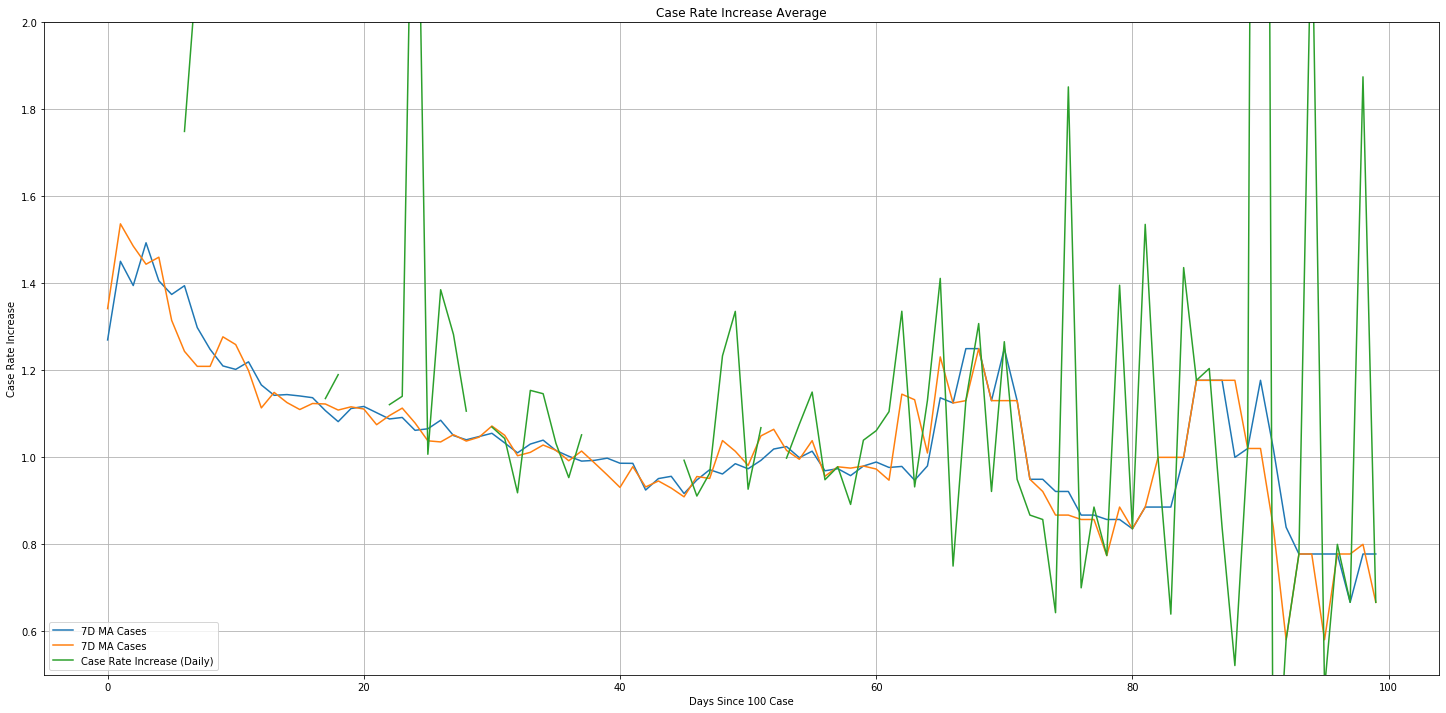

In [192]:
# Plot the global average case rate per day past 100th case.
plt.figure(figsize=(25, 12))
plt.plot(country_df_mean.index, country_df_mean['7D_MA_cases'], label='7D MA Cases')
plt.plot(country_df_mean.index, country_df_mean['5D_MA_cases'], label='7D MA Cases')
plt.plot(country_df_mean.index, country_df_mean['case_rate_inc'], label='Case Rate Increase (Daily)')
plt.title('Case Rate Increase Average')
plt.xlabel('Days Since 100 Case')
#plt.legend()
plt.ylabel('Case Rate Increase')
plt.ylim(0.5, 2)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

In [193]:
# Drop columns not needed in global average table
country_df_mean.drop(['cases', 'deaths', 'Cum Cases', 'Cum Deaths', 'popData2018'], axis=1, inplace=True)

In [194]:
# Slice first day off so it matches the index of country_df_2, rename columns as 'global'
country_df_mean = country_df_mean.loc[(country_df_mean.index > 0)]
country_df_mean.rename(columns={"case_rate_inc": "case_rate_inc_global", "death_rate_inc": "death_rate_inc_global",\
                                '5D_MA_cases':'5D_MA_cases_global', '5D_MA_deaths': '5D_MA_deaths_global', '7D_MA_cases': '7D_MA_cases_global', '7D_MA_deaths':'7D_MA_deaths_global'}, inplace=True)
country_df_mean.head(3)

,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
flag,,,,,,
1.0,inf,inf,1.537002,1.333333,1.450839,NaN
2.0,1.473564,inf,1.485854,1.333333,1.395085,NaN
3.0,inf,inf,1.444117,1.166667,1.493450,1.333333


In [195]:
# Create a secondary country df that is prepped to be merged with the global mean one.
# Rolling 5 day averages for cases and deaths calculated so that they can be used to predict future deaths/ cases 
country_df_2 = country_df.drop(['5D_MA_cases', '5D_MA_deaths', '7D_MA_cases', '7D_MA_deaths', 'case_rate_inc', 'death_rate_inc'], axis=1)
#country_df_2.join(country_df_mean, on=[country_df_mean.index,country_df.flag], how='outer')
#country_df_2.loc[(country_df_2['countriesAndTerritories'] == 'United_Kingdom')].tail()
country_df_2['5D_MA_cases'] = country_df.groupby("countriesAndTerritories")['cases'].rolling(window=5).mean().reset_index(0,drop=True)
country_df_2['5D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['deaths'].rolling(window=5).mean().reset_index(0,drop=True)
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[50:52]

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths
12632,2020-02-19,0,0,United_Kingdom,66488991.0,Europe,9,0,0.0,0.0,0.0
12631,2020-02-20,0,0,United_Kingdom,66488991.0,Europe,9,0,0.0,0.0,0.0


In [196]:
# Find the country with the longest number of days since 100th case (China) and extrapolate each countries number of days to that amount with their own respective dates, etc added.
# 'cum_7D_MA_deaths_global' is an attribute calculating the cumlative relative deathrate since the last real value. So the number at the last real value is '1' and if the subsecquent number was 2, tha would mean the daily deaths that day were twice as much as the day before. Initially populated with 1's and subsequently calculated later on.
# '7D_DeathPred' initially populated with the daily death tally on the day with the last real data, this is then multiplied by the 'cum_7D_MA_deaths_globally' to find the prediced daily deaths for any day in the future.

for country in top_count:
    country_len = len(country_df_2.loc[(country_df_2['countriesAndTerritories'] == country) & (country_df_2['flag'] > 0)])
    blank_df = pd.DataFrame(columns=['flag', 'countriesAndTerritories', 'dateRep', 'popData2018', 'cum_7D_MA_deaths_global', '7D_DeathPred'], index=np.arange(len(country_df_mean) - country_len))
    for i in range(len(country_df_mean) - country_len):
        date_value_max = pd.DateOffset(i + 1) + country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max()
        pop_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['popData2018'].iloc[0]
        #continentExp_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['continentExp'].iloc[0]
        deathpred_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['5D_MA_deaths'].iloc[0]
        cumprod_value = 1
        blank_df = blank_df.append({'flag': (i + country_len + 1), 'countriesAndTerritories': country, 'dateRep': date_value_max, 'popData2018': pop_value, 'continentExp': continentExp_value, 'cum_7D_MA_deaths_global': 1, '7D_DeathPred': deathpred_value}, ignore_index=True)
    country_df_2 = pd.concat([country_df_2, blank_df])
country_df_2.loc[country_df_2['countriesAndTerritories'] == 'United_Kingdom'].tail()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred
89,2020-06-08,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,95,NaN,NaN,1,762.0
90,2020-06-09,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,96,NaN,NaN,1,762.0
91,2020-06-10,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,97,NaN,NaN,1,762.0
92,2020-06-11,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,98,NaN,NaN,1,762.0
93,2020-06-12,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,99,NaN,NaN,1,762.0


In [197]:
# Merge global average attributes into country_df_2, so on 'days past 100 case' there is an global mean change in deaths/ cases at 1, 5 and 7 day increments.

country_df_2 = country_df_2.merge(country_df_mean, left_on=country_df_2.flag, right_on=country_df_mean.index)
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:62]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
5584,60.0,2020-05-04,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,60,NaN,NaN,1,762.0,1.061337,1.182667,0.973178,1.096045,0.989265,1.012503
5633,61.0,2020-05-05,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,61,NaN,NaN,1,762.0,1.105122,0.515446,0.947480,0.976868,0.976782,0.976868
5683,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,62,NaN,NaN,1,762.0,1.336026,inf,1.145295,0.913602,0.979132,0.865827


In [198]:
# First stage of 'cum_7D_MA_deaths_global' is to populate the column with the global running average value.

country_df_2['cum_7D_MA_deaths_global'] = country_df_2['cum_7D_MA_deaths_global'] * country_df_2['7D_MA_deaths_global']
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:64]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
5584,60.0,2020-05-04,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,60,NaN,NaN,1.0125,762.0,1.061337,1.182667,0.973178,1.096045,0.989265,1.012503
5633,61.0,2020-05-05,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,61,NaN,NaN,0.976868,762.0,1.105122,0.515446,0.947480,0.976868,0.976782,0.976868
5683,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,62,NaN,NaN,0.865827,762.0,1.336026,inf,1.145295,0.913602,0.979132,0.865827
5733,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,63,NaN,NaN,0.893468,762.0,0.932096,1.196281,1.132505,0.893468,0.947480,0.893468
5783,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,64,NaN,NaN,1,762.0,1.131054,0.522222,1.009991,1.000000,0.980342,1.000000


In [199]:
# Second stage of 'cum_7D_MA_deaths_global' is to convert to float, then run .cumprod, to calculate the cumulative sum relative to the last real value.
# '7D_DeathPred' is then calculated by multiplying the last realy value of daily deaths with the 'cum_7D_MA_deaths_global' to find the predicted value based on the 7D moving average changing in death rate.

country_df_2['cum_7D_MA_deaths_global'] = country_df_2['cum_7D_MA_deaths_global'].astype(float)
country_df_2['cum_7D_MA_deaths_global'] = country_df_2.groupby('countriesAndTerritories')['cum_7D_MA_deaths_global'].cumprod()
country_df_2['7D_DeathPred'] = country_df_2['7D_DeathPred'] * country_df_2['cum_7D_MA_deaths_global']
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[20:44]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
2677,21.0,2020-03-26,1452.0,41.0,United_Kingdom,66488991.0,Europe,9529.0,463.0,21,1109.2,57.2,NaN,NaN,inf,inf,1.075111,1.176107,1.102686,1.095800
2802,22.0,2020-03-27,2129.0,115.0,United_Kingdom,66488991.0,Europe,11658.0,578.0,22,1328.0,69.0,NaN,NaN,1.121214,inf,1.096038,1.146548,1.088281,1.074779
2924,23.0,2020-03-28,2885.0,181.0,United_Kingdom,66488991.0,Europe,14543.0,759.0,23,1772.0,95.6,NaN,NaN,1.140417,1.551369,1.113218,1.163279,1.091761,1.188312
3041,24.0,2020-03-29,2546.0,260.0,United_Kingdom,66488991.0,Europe,17089.0,1019.0,24,2087.8,136.8,NaN,NaN,2.791218,1.182506,1.079111,1.073118,1.062150,1.134391
3155,25.0,2020-03-30,2433.0,209.0,United_Kingdom,66488991.0,Europe,19522.0,1228.0,25,2289.0,161.2,NaN,NaN,1.007112,inf,1.038032,1.187367,1.065701,1.154306
3268,26.0,2020-03-31,2619.0,180.0,United_Kingdom,66488991.0,Europe,22141.0,1408.0,26,2522.4,189.0,NaN,NaN,1.385513,inf,1.035472,1.106272,1.085361,1.091748
3380,27.0,2020-04-01,3009.0,381.0,United_Kingdom,66488991.0,Europe,25150.0,1789.0,27,2698.4,242.2,NaN,NaN,1.282538,inf,1.052251,1.140946,1.050142,1.095094
3489,28.0,2020-04-02,4324.0,743.0,United_Kingdom,66488991.0,Europe,29474.0,2532.0,28,2986.2,354.6,NaN,NaN,1.106275,1.586563,1.037450,1.103810,1.040417,1.103265
3592,29.0,2020-04-03,4244.0,389.0,United_Kingdom,66488991.0,Europe,33718.0,2921.0,29,3325.8,380.4,NaN,NaN,inf,inf,1.046481,1.057119,1.047878,1.079012
3694,30.0,2020-04-04,4450.0,684.0,United_Kingdom,66488991.0,Europe,38168.0,3605.0,30,3729.2,475.4,NaN,NaN,1.069824,inf,1.072042,1.061211,1.055368,1.059669


In [200]:
# '7D_Full_Death' is created initiall using the daily predicted deaths, then the .fillna fills in the previous values with the real daily deaths from the original 'deaths' column

country_df_2['7D_Full_Death'] = country_df_2['7D_DeathPred']
country_df_2['7D_Full_Death'].fillna(country_df_2.deaths, inplace=True)
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:64]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,...,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global,7D_Full_Death
5584,60.0,2020-05-04,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,60,...,NaN,0.946764,721.433969,1.061337,1.182667,0.973178,1.096045,0.989265,1.012503,721.433969
5633,61.0,2020-05-05,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,61,...,NaN,0.924863,704.745975,1.105122,0.515446,0.947480,0.976868,0.976782,0.976868,704.745975
5683,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,62,...,NaN,0.800772,610.187884,1.336026,inf,1.145295,0.913602,0.979132,0.865827,610.187884
5733,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,63,...,NaN,0.715463,545.183130,0.932096,1.196281,1.132505,0.893468,0.947480,0.893468,545.183130
5783,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,64,...,NaN,0.715463,545.183130,1.131054,0.522222,1.009991,1.000000,0.980342,1.000000,545.183130


In [201]:
# '7D_Full_Death_cum' calculates the cumulative total of the original real values with the future predicted values.

country_df_2['7D_Full_Death_cum'] = country_df_2.groupby('countriesAndTerritories')['7D_Full_Death'].cumsum()

In [205]:
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[50:100]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,...,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global,7D_Full_Death,7D_Full_Death_cum
5129,51.0,2020-04-25,5386.0,768.0,United_Kingdom,66488991.0,Europe,143464.0,19506.0,51,...,NaN,NaN,1.068250,1.026761,1.049324,0.952329,0.993037,0.930462,768.000000,19506.000000
5180,52.0,2020-04-26,4913.0,813.0,United_Kingdom,66488991.0,Europe,148377.0,20319.0,52,...,NaN,NaN,inf,inf,1.064516,0.971065,1.019161,0.971408,813.000000,20319.000000
5231,53.0,2020-04-27,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,53,...,0.990342,754.640366,0.998283,1.183656,1.016027,1.069127,1.024829,0.990342,754.640366,21073.640366
5282,54.0,2020-04-28,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,54,...,0.933159,711.067471,1.076224,0.952735,0.995585,1.000013,0.999258,0.942260,711.067471,21784.707837
5333,55.0,2020-04-29,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,55,...,0.985953,751.296367,1.150145,1.118499,1.038432,1.124932,1.014202,1.056575,751.296367,22536.004204
5384,56.0,2020-04-30,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,56,...,0.976406,744.021389,0.948588,1.103003,0.956580,1.016074,0.969135,0.990317,744.021389,23280.025593
5435,57.0,2020-05-01,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,57,...,0.955301,727.939392,0.978343,0.683731,0.978320,0.901294,0.973984,0.978385,727.939392,24007.964985
5484,58.0,2020-05-02,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,58,...,0.914735,697.027818,0.891773,1.323411,0.975259,1.018129,0.957998,0.957536,697.027818,24704.992803
5534,59.0,2020-05-03,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,59,...,0.935072,712.524990,1.039427,1.066085,0.980002,0.988161,0.980002,1.022233,712.524990,25417.517793
5584,60.0,2020-05-04,NaN,NaN,United_Kingdom,66488991.0,Africa,NaN,NaN,60,...,0.946764,721.433969,1.061337,1.182667,0.973178,1.096045,0.989265,1.012503,721.433969,26138.951762


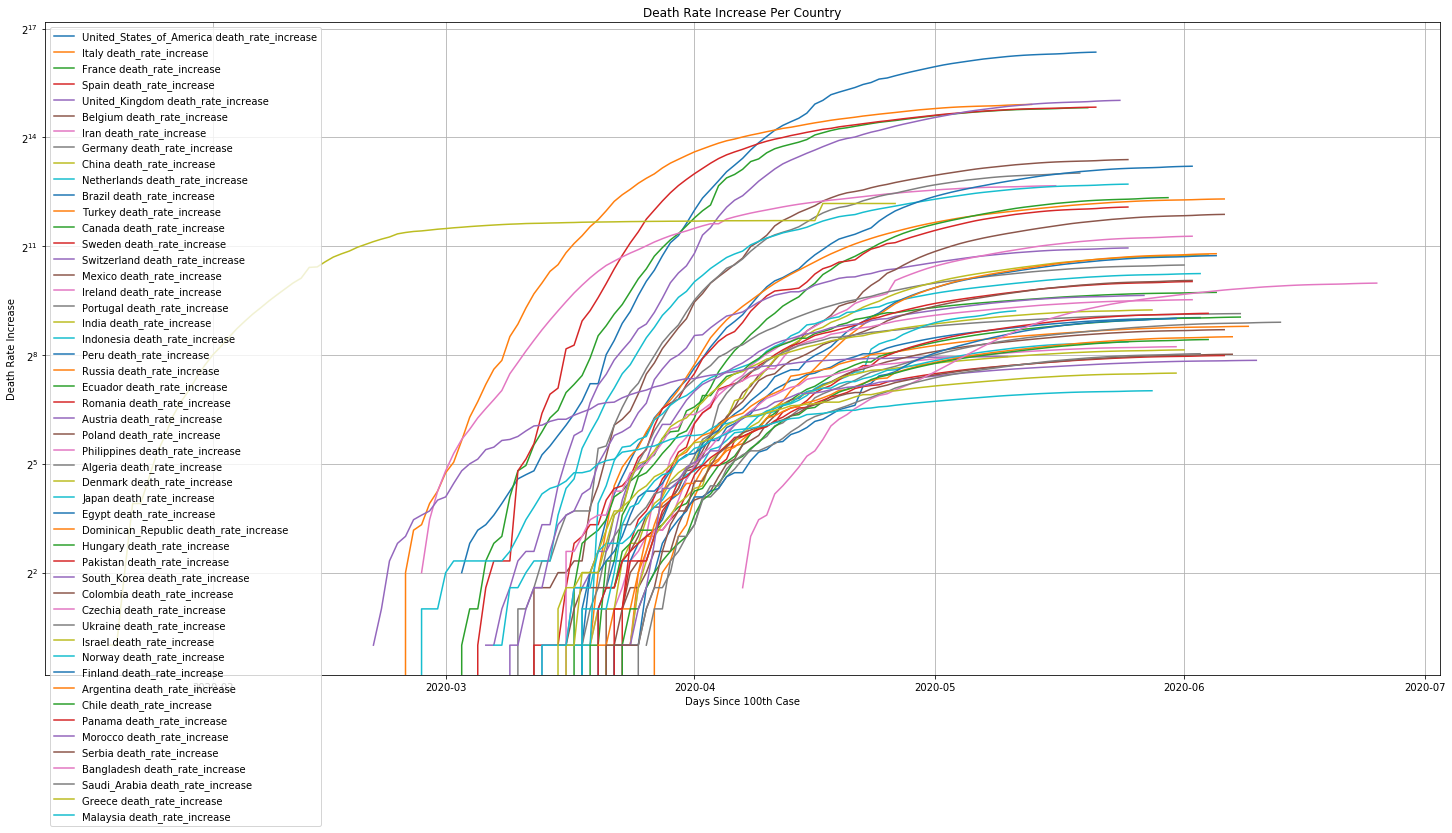

In [203]:
# Visualising the Linear Regression results for each country, cumulative totals with real and future predicted values up to the maxmum 'days since 100 case' which is China
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(country_df_2[country_df_2["countriesAndTerritories"] == country]["dateRep"],
             country_df_2[country_df_2["countriesAndTerritories"] == country]["7D_Full_Death_cum"], label=f"{country} death_rate_increase")
plt.title('Death Rate Increase Per Country')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Death Rate Increase')
plt.ylim()
plt.yscale('log', basey=2)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()